# **Importing Libraries**

In [1]:
#Audio Processing Libraries
import librosa
from scipy import signal

#For Playing Audio
import IPython.display as ipd

#Array Processing
import numpy as np

#Data Visualization 
import matplotlib.pyplot as plt

# **Load Audio Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extract Data
!unzip -uq "drive/My Drive/audio.zip"

**Sampling Rate** is defined as the no. of samples per second. For example, consider an audio wave of 2 seconds with a sampling rate of 16,000 (that is 16,000 samples per second). Now, we will have 32,000 samples recorded at different intervals of 2 seconds

In [4]:
# import Emergency vechile sound data
path='emergency.wav'
emergency,sample_rate    = librosa.load(path, sr = 16000)

path='non emergency.wav'
non_emergency,sample_rate= librosa.load(path, sr =16000)


# **Duration of audio clips**

In [5]:
duration1 = librosa.get_duration(emergency, sr=16000)
duration2 = librosa.get_duration(non_emergency, sr=16000)

print('Duration of emergency or non emergency (in min)', duration1/60, duration2/60)

Duration of emergency or non emergency (in min) 22.920290625 27.160834375


# **Preparing Data**

**Let us break the audio into chunks of 2 seconds. So, let us define the function for the same task**

In [6]:
def prepare_data(audio_data, num_of_samples=32000, sr=16000):

  data=[]
  for offset in range(0, len(audio_data), sr):
    start = offset
    end= offset + num_of_samples
    chunk = audio_data[start:end]

    if(len(chunk)== 32000):
      data.append(chunk)
  
  return data

**call the above function**

In [7]:
# Prepare audio chunks
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)
print("No. of chunks of emergency and non_emergency:", len(emergency), len(non_emergency))

No. of chunks of emergency and non_emergency: 1374 1628


**Let's Listen to some of the clip**

In [8]:
ipd.Audio(emergency[136], rate=16000)

In [9]:
ipd.Audio(non_emergency[10], rate=16000)

# **Visualization of Audio Data**

Text(0, 0.5, 'Amplitude')

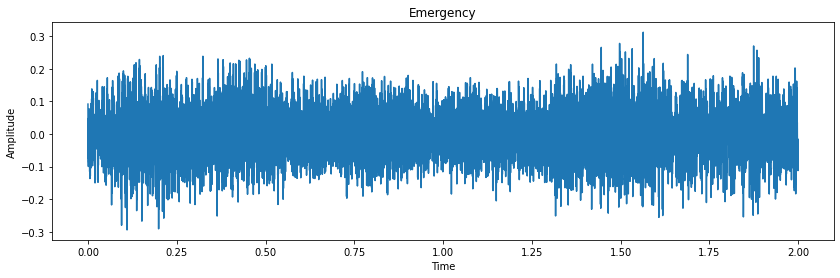

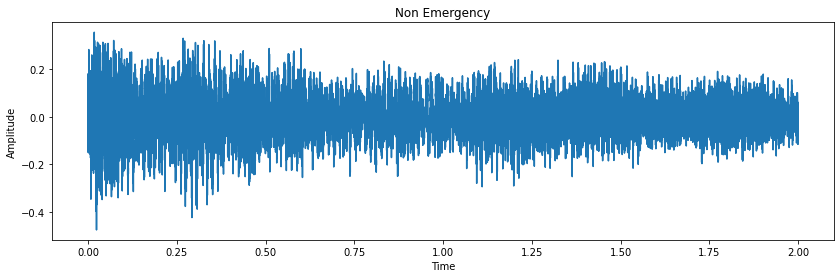

In [10]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0,2, num=32000), emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.figure(figsize=(14,4))
plt.plot(np.linspace(0,2, num=32000), emergency[102])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

**combine emergency and non emergency chunks**

In [11]:
audio= np.concatenate([emergency, non_emergency])

In [12]:
# assign Labels
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

# concatenate lables
labels = np.concatenate([labels1, labels2])

**Take a Glance at the shape of combined data**

In [13]:
print(audio.shape)

(3002, 32000)


# **Split into train and Validation set**

 Now we will train the model on 90% and validation on the remaining 10%

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid= train_test_split(np.array(audio), np.array(labels),
                                                     stratify= labels,test_size=0.1,
                                                     random_state=777, shuffle=True)

In [15]:
x_train.shape, x_valid.shape

((2701, 32000), (301, 32000))

The input must be 3 dimensional array-(no.of examples , timestamp, features)

so lets reshape our input array according to the required shape

In [16]:
x_train_features = x_train.reshape(len(x_train),-1,1)
x_valid_features = x_valid.reshape(len(x_valid),-1,1)

print('Reshaped array size', x_train_features.shape)

Reshaped array size (2701, 32000, 1)


# **Model Architecture**

Lets define the model architecture using conv1D layers as it performs convolution only along one dimension

In [17]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K

# CNN based Deep Learning Model Architecture

def conv1d(x_train):
  K.clear_session()
  inputs = Input(shape=(x_train.shape[1],x_train.shape[2]))

  #First Conv1D layer
  conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)

  #Dense Layer 
  conv = Dense(16, activation='relu')(conv)
  outputs = Dense(1,activation='sigmoid')(conv)

  model = Model(inputs, outputs)
  
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  
  return model, model_checkpoint


# **call the model**

In [18]:
model, model_checkpoint = conv1d(x_train_features)

In [19]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32000, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 32000, 8)          112       
_________________________________________________________________
dropout (Dropout)            (None, 32000, 8)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16000, 8)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 16)         1424      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16000, 16)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8000, 16)         

# **Lets train the model for 10 epochs with batch size of 32:**

In [20]:
history=model.fit(x_train_features, y_train ,epochs=10, callbacks=[model_checkpoint], batch_size=32, validation_data=(x_valid_features,y_valid))

Epoch 1/10
83/85 [============================>.] - ETA: 0s - loss: 0.6218 - acc: 0.6947
Epoch 00001: val_acc improved from -inf to 0.80399, saving model to best_model.hdf5
85/85 [==============================] - 2s 19ms/step - loss: 0.6216 - acc: 0.6960 - val_loss: 0.5942 - val_acc: 0.8040
Epoch 2/10
84/85 [============================>.] - ETA: 0s - loss: 0.4786 - acc: 0.8211
Epoch 00002: val_acc improved from 0.80399 to 0.81728, saving model to best_model.hdf5
85/85 [==============================] - 1s 16ms/step - loss: 0.4780 - acc: 0.8212 - val_loss: 0.5001 - val_acc: 0.8173
Epoch 3/10
84/85 [============================>.] - ETA: 0s - loss: 0.3851 - acc: 0.8586
Epoch 00003: val_acc improved from 0.81728 to 0.87043, saving model to best_model.hdf5
85/85 [==============================] - 1s 17ms/step - loss: 0.3855 - acc: 0.8586 - val_loss: 0.4283 - val_acc: 0.8704
Epoch 4/10
83/85 [============================>.] - ETA: 0s - loss: 0.3477 - acc: 0.8633
Epoch 00004: val_acc did n

# **Load the best model**

In [21]:
model.load_weights('best_model.hdf5')

In [22]:
# Evaluate teh model
_, acc = model.evaluate(x_valid_features,y_valid)
print("Validation Accuracy:",acc)

10/10 [==============================] - 0s 6ms/step - loss: 0.3645 - acc: 0.8771
Validation Accuracy: 0.8770763874053955


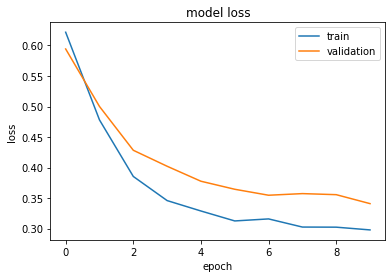

In [23]:
# Summarize History for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

**Let us make predictions on the hold out set**

In [24]:
ind=35
test_audio = x_valid[ind]
ipd.Audio(test_audio,rate=16000)

In [25]:
feature = x_valid_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 

print("Prediction:",pred)

Prediction: emergency


# **By Using LSTM**

In [33]:
x_train_features  = x_train.reshape(len(x_train),-1,160)
x_valid_features = x_valid.reshape(len(x_valid),-1,160)

print("Reshaped Array Size",x_train_features.shape)

Reshaped Array Size (2701, 200, 160)


In [34]:
from keras.layers import LSTM
def lstm_model(x_train):

  
  inputs = Input(shape=(x_train.shape[1],x_train.shape[2]))

  #lstm
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)
  
  #dense
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)
  
  model = Model(inputs, x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  
  return model

In [35]:
model = lstm_model(x_train_features)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 160)]        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               147968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 156,289
Trainable params: 156,289
Non-trainable params: 0
_________________________________________________________________


In [36]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [37]:
history=model.fit(x_train_features, y_train, epochs=10, callbacks=[mc], batch_size=32, validation_data=(x_valid_features,y_valid))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6816 - acc: 0.6020
Epoch 00001: val_acc improved from -inf to 0.60797, saving model to best_model.hdf5
85/85 [==============================] - 2s 18ms/step - loss: 0.6816 - acc: 0.6020 - val_loss: 0.6558 - val_acc: 0.6080
Epoch 2/10
81/85 [===========================>..] - ETA: 0s - loss: 0.6415 - acc: 0.6516
Epoch 00002: val_acc did not improve from 0.60797
85/85 [==============================] - 1s 14ms/step - loss: 0.6432 - acc: 0.6472 - val_loss: 0.6633 - val_acc: 0.6080
Epoch 3/10
82/85 [===========================>..] - ETA: 0s - loss: 0.6736 - acc: 0.5838
Epoch 00003: val_acc improved from 0.60797 to 0.61130, saving model to best_model.hdf5
85/85 [==============================] - 1s 14ms/step - loss: 0.6735 - acc: 0.5857 - val_loss: 0.6696 - val_acc: 0.6113
Epoch 4/10
81/85 [===========================>..] - ETA: 0s - loss: 0.6462 - acc: 0.6285
Epoch 00004: val_acc improved from 0.61130 to 0.70100, saving m

In [38]:
model.load_weights('best_model.hdf5')

In [39]:
_,acc = model.evaluate(x_valid_features,y_valid)
print("Accuracy:",acc)

10/10 [==============================] - 0s 7ms/step - loss: 0.5456 - acc: 0.8671
Accuracy: 0.8671096563339233


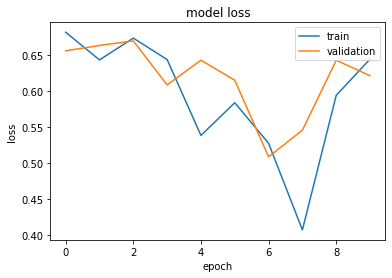

In [40]:
# Summarize History for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [41]:
ind=1
test_audio = x_valid[ind]
ipd.Audio(test_audio,rate=16000)

In [42]:
feature = x_valid_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 
print("Prediction:",pred)

Prediction: emergency


# **Spectrogram**

Ever heard of a spectrogram? It’s a 2D plot between time and frequency where each point in the plot represents the amplitude of a particular frequency at a particular time in terms of intensity of color. In simple terms, the spectrogram is a spectrum (broad range of colors) of frequencies as it varies with time.

Let us define a function that computes the spectrogram. Before that, we need to understand how the spectrogram is computed.

Spectrogram accepts the raw audio wave and then breaks it into chunks or windows and then applies FFT on each window to compute the frequencies.

Coming to the parameters for computing spectrogram:

nperseg = Size of the window i.e. no. of samples in each chunk
noverlap= No. of overlapping samples between each window

In [43]:
def log_specgram(audio, sample_rate, eps=1e-10):
    nperseg  = 320
    noverlap = 160
    freqs, times, spec = signal.spectrogram(audio,fs=sample_rate, nperseg=nperseg,noverlap=noverlap,detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

**Define a function for representing spectrogram:**



In [44]:
def plot(spectrogram,label):
  fig = plt.figure(figsize=(14, 8))
  ax = fig.add_subplot(211)
  ax.imshow(spectrogram.T, aspect='auto', origin='lower',extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  ax.set_title('Spectrogram of '+label)
  ax.set_ylabel('Freqs in Hz')
  ax.set_xlabel('Seconds')

**Compute the spectrogram**

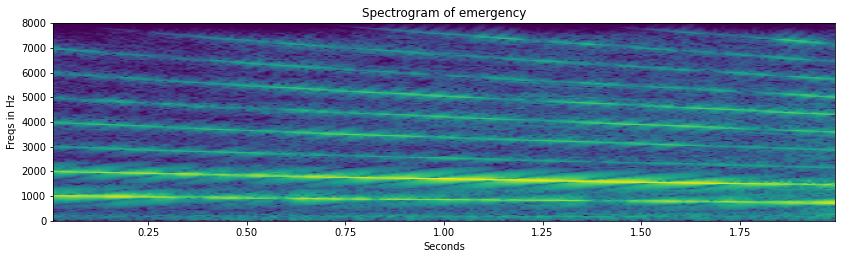

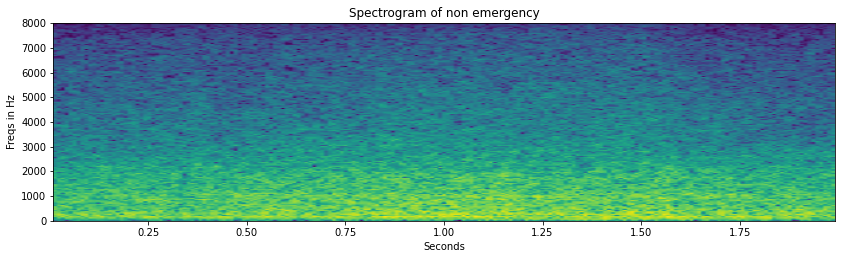

In [45]:
freqs, times, spectrogram = log_specgram(emergency[300], sample_rate)
plot(spectrogram,"emergency")

freqs, times, spectrogram = log_specgram(non_emergency[300], sample_rate)
plot(spectrogram,"non emergency")

In [46]:
spectrogram.shape

(199, 161)

**Extract the spectrogram features**



In [49]:
def extract_spectrogram_features(x_train):
  features=[]
  for i in x_train:
    _, _, spectrogram = log_specgram(i, sample_rate)
    
    mean = np.mean(spectrogram, axis=0)
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std
    
    features.append(spectrogram)

  return np.array(features)

In [50]:
x_train_features  = extract_spectrogram_features(x_train)
x_valid_features = extract_spectrogram_features(x_valid)

# **Define architecture**

Now, we will define the LSTM architecture for solving the task

In [51]:
def lstm(x_train):
  K.clear_session()
  inputs = Input(shape=(x_train.shape[1],x_train.shape[2]))

  #lstm
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)
  
  #dense
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)
  
  model = Model(inputs, x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

  mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  
  return model,mc

In [52]:
# Define the model
model, mc = lstm(x_train_features)

In [53]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 199, 161)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               148480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 156,801
Trainable params: 156,801
Non-trainable params: 0
_________________________________________________________________


**Train the model**

In [54]:
history=model.fit(x_train_features, y_train, epochs=10, callbacks=[mc], batch_size=32, validation_data=(x_valid_features,y_valid))

Epoch 1/10
81/85 [===========================>..] - ETA: 0s - loss: 0.6442 - acc: 0.6246
Epoch 00001: val_acc improved from -inf to 0.76412, saving model to best_model.hdf5
85/85 [==============================] - 2s 19ms/step - loss: 0.6412 - acc: 0.6275 - val_loss: 0.5554 - val_acc: 0.7641
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.4412 - acc: 0.8049
Epoch 00002: val_acc improved from 0.76412 to 0.83721, saving model to best_model.hdf5
85/85 [==============================] - 1s 14ms/step - loss: 0.4412 - acc: 0.8049 - val_loss: 0.4268 - val_acc: 0.8372
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.3162 - acc: 0.8812
Epoch 00003: val_acc did not improve from 0.83721
85/85 [==============================] - 1s 14ms/step - loss: 0.3162 - acc: 0.8812 - val_loss: 0.5890 - val_acc: 0.8239
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.2640 - acc: 0.9130
Epoch 00004: val_acc improved from 0.83721 to 0.92359, saving m

In [56]:
# Load the weights of the best model:
model.load_weights('best_model.hdf5')

**Evaluating the performance of the model on validation set:**

In [57]:
_,acc = model.evaluate(x_valid_features,y_valid)
print("Accuracy:",acc)

10/10 [==============================] - 0s 7ms/step - loss: 0.1506 - acc: 0.9468
Accuracy: 0.9468438625335693


**Inference**

Let us make predictions on the validation data

In [63]:
ind=1
test_audio = x_valid[ind]
ipd.Audio(test_audio,rate=16000)

In [64]:
feature = x_valid_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 
print("Prediction:",pred)

Prediction: emergency


**Lets train conv1d on the same spectrogram features. So, lets define the conv1d model**

In [65]:
model, mc = conv1d(x_train_features)

In [66]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 199, 161)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 199, 8)            16752     
_________________________________________________________________
dropout (Dropout)            (None, 199, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 99, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 99, 16)            1424      
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 16)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 16)           

**Training the model:**

In [67]:
history=model.fit(x_train_features, y_train, epochs=10, callbacks=[mc], batch_size=32, validation_data=(x_valid_features,y_valid))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6208 - acc: 0.6398
Epoch 00001: val_acc improved from -inf to 0.83389, saving model to best_model.hdf5
85/85 [==============================] - 1s 8ms/step - loss: 0.6208 - acc: 0.6398 - val_loss: 0.4932 - val_acc: 0.8339
Epoch 2/10
84/85 [============================>.] - ETA: 0s - loss: 0.3602 - acc: 0.8438
Epoch 00002: val_acc improved from 0.83389 to 0.88040, saving model to best_model.hdf5
85/85 [==============================] - 1s 6ms/step - loss: 0.3594 - acc: 0.8438 - val_loss: 0.3289 - val_acc: 0.8804
Epoch 3/10
76/85 [=========================>....] - ETA: 0s - loss: 0.2586 - acc: 0.8923
Epoch 00003: val_acc improved from 0.88040 to 0.90365, saving model to best_model.hdf5
85/85 [==============================] - 0s 6ms/step - loss: 0.2554 - acc: 0.8934 - val_loss: 0.2738 - val_acc: 0.9037
Epoch 4/10
78/85 [==========================>...] - ETA: 0s - loss: 0.1911 - acc: 0.9223
Epoch 00004: val_acc did not 

In [68]:
# Load the best model
model.load_weights('best_model.hdf5')

In [69]:
# Evaluating the performance of the model:
_,acc = model.evaluate(x_valid_features,y_valid)
print("Accuracy:",acc)

10/10 [==============================] - 0s 4ms/step - loss: 0.1448 - acc: 0.9535
Accuracy: 0.9534883499145508


**Inference:**

Let us make predictions on the validation data

In [71]:
ind=1
test_audio = x_valid[ind]
ipd.Audio(test_audio,rate=16000)

In [72]:
feature = x_valid_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 

print("Predicion:",pred)

Predicion: emergency
